# Asset Pricing Model
#### Author: Ryumei Nakada
##### From Applied Computational Economics and Finance(2002)  8.6.1(p224), 9.9.1(305p)

純粋交換経済において,無限に生きるエージェントが消費と投資を分配する問題について考える.

$s_t$: Shares.

$p_t$: Price.

$d_t$: Dividend(consumption good) per share.

$c_t$: Consumption level.

$U(c_t)$: utility.

目的は, maximize the sum of discounted expected utilities $U(c_t)$ over time.

制約条件は,

$p_t(s_{t+1} - s_t) = d_t s_t - c_t$

すなわち,

$s_{t+1} = s_t + (d_t s_t - c_t) / p_t$

各期に所有する株式が増えた分の価値が, 配られた配当から消費を除いた額に等しくなければならないことを表す.

いくつかの正則条件のもとで, エージェントの動的最適化問題は, 次の一回条件を満たすただひとつの解を持つことが知られている.

$U'(c_t) p_t = \delta E_t[U'(c_{t+1})(p_{t+1} + d_{t+1})]$

外生的な過程$d_{t+1} = g(d_t, e_{t+1})$と, 次の条件により定まる株価$p$
$U'(d)p(d) - \delta E_\epsilon[U'(g(d, \epsilon))(p(g(d, \epsilon)) + g(d, \epsilon))] = 0$

ここで, $p(d) \approx \phi(d)c$と近似する. $n$個のBasis functions$\phi_j$と$n$個のCollocationCollocation nodes$s_j$を選び, 次の線形方程式
$$
(U'(d) \phi(d) - \delta E_\epsilon [U'(g(d, \epsilon)) \phi(g(d, \epsilon))]) c = \delta E_\epsilon [U'(g(d, \epsilon))g(d, \epsilon)]
$$
を$c$について解く事を考える.

たとえば, 

$U(c) = (c^{1 - \beta} - 1) / (1 - \beta)$,

$d_{t+1} = \bar d + \gamma (d_t - \bar d) + \epsilon_{t+1}$

$\epsilon \sim N(0, \sigma^2) \ i.i.d.$

と具体的に与えた場合の$c$を計算する. 期待値を計算する際はGaussian Quadratureを使う.

In [1]:
using QuantEcon
using CompEcon
using Plots

Model Parameters

In [2]:
dbar = 1.
gamma = .5
beta = .4 # coefficient of risk aversion
sigma = .1
delta = .9 

0.9

Discretize the shock

In [20]:
m = 3 # 3 discrete points
e, w = qnwnorm(m, 0, sigma^2) # Gaussian quadrature nodes and probability weights

([-0.173205, 0.0, 0.173205], [0.166667, 0.666667, 0.166667])

Basis functions and collocation nodes.

10 Chebyshev polynomials and the corresponding standard Chebyshev nodes are selected.

In [4]:
n = 10
dmin = dbar + minimum(e)/(1 - gamma)
dmax = dbar + maximum(e)/(1 - gamma)
fspace = fundefn(:cheb, n, dmin, dmax) # define basis
dnode = funnode(fspace)[1] # standard approx. nodes

1.3464101615137753

Solve the decision model

In [23]:
LHS = diagm(dnode .^ (-beta)) * funbase(fspace, dnode) # dnode * interpolation coefficient matrix evaluated @ dnode
RHS = 0
for k in 1:m
    dnext = dbar + gamma * (dnode - dbar) + e[k]
    LHS -= delta * w[k] * diagm(dnext .^ (-beta)) * funbase(fspace, dnext)
    RHS += delta * w[k] * dnext .^ (1 - beta)
end
c = LHS\RHS

10-element Array{Float64,1}:
  8.92897    
  1.43242    
 -0.0576017  
  0.00570713 
 -0.000674693
  8.76658e-5 
 -1.20824e-5 
  1.73445e-6 
 -2.56175e-7 
  3.78434e-8 

In [24]:
function nodeunif(n::Int, a, b)
    x = linspace(a, b, n)
    return x, x
end

nodeunif (generic function with 1 method)

Compute the response function and approximation residuals

In [25]:
d = linspace(dmin, dmax, 10*n)
p = funeval(c, fspace, d)[1]
Eh = 0
for k in 1:m
    dnext = dbar + gamma * (d - dbar) + e[k] # d_{t+1}
    h = diagm(dnext .^ (-beta)) * (funeval(c, fspace, dnext)[1] + dnext)
    Eh += delta * w[k] * h # calclulates the expectation
end
resid = d .^ (-beta) .* funeval(c, fspace, d)[1] - Eh

100×1 Array{Float64,2}:
  9.69909e-9 
 -4.10031e-9 
 -9.05546e-9 
 -8.73599e-9 
 -5.67938e-9 
 -1.61879e-9 
  2.32906e-9 
  5.51002e-9 
  7.60792e-9 
  8.54464e-9 
  8.40115e-9 
  7.35614e-9 
  5.63921e-9 
  ⋮          
  3.63622e-9 
  4.07397e-9 
  4.06464e-9 
  3.54986e-9 
  2.52165e-9 
  1.04535e-9 
 -7.12502e-10
 -2.4512e-9  
 -3.69687e-9 
 -3.75697e-9 
 -1.66767e-9 
  3.86678e-9 

In [26]:
p

100×1 Array{Float64,2}:
  7.43246
  7.46727
  7.50191
  7.53637
  7.57065
  7.60477
  7.63872
  7.6725 
  7.70613
  7.73959
  7.7729 
  7.80606
  7.83906
  ⋮      
 10.0289 
 10.0547 
 10.0804 
 10.106  
 10.1316 
 10.1571 
 10.1825 
 10.2079 
 10.2332 
 10.2585 
 10.2837 
 10.3089 


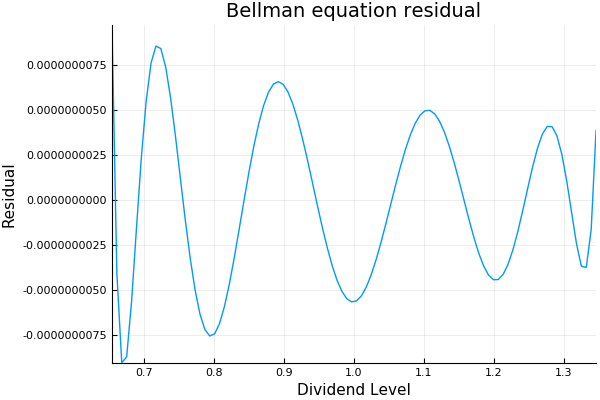

In [37]:
plot(d, resid, xlabel="Dividend Level", ylabel="Residual", title="Bellman equation residual", label="")


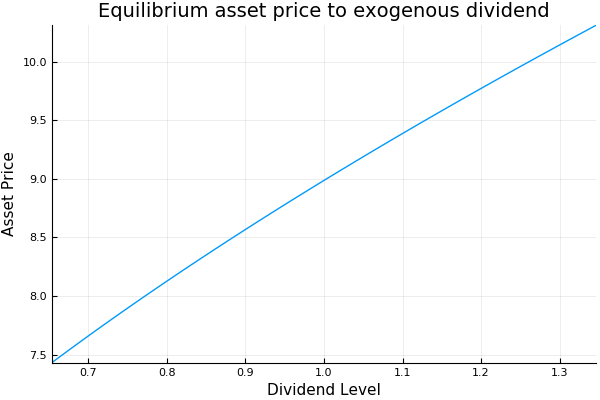

In [36]:
plot(d, p, xlabel="Dividend Level", ylabel="Asset Price", title="Equilibrium asset price to exogenous dividend", label="")